# Résolution d’une équation quadratique par Grover
**Crédit Agricole : Ateliers Quantiques 2025**  
Atelier 3 — Partie 2

## Objectif

Nous voulons résoudre l’équation :


$$ (7x^2 + 11x + 5) \bmod 32 = 13 $$ 

- L’espace des solutions est $\{0,1,\dots,31\}$.
- Il nous faut donc **5 qubits** pour représenter $x$.
- Nous allons construire un **oracle quantique** qui marque les états $|x⟩$ satisfaisant cette équation.
- Ensuite, l’algorithme de **Grover** amplifie la probabilité d’obtenir ces états lors de la mesure.


In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import numpy as np

backend = AerSimulator()


## Superposition uniforme

On applique des portes de Hadamard sur les 5 qubits représentant $x$.  
Cela crée l’état :

$$ |\psi_0⟩ = \frac{1}{\sqrt{32}} \sum_{x=0}^{31} |x⟩ $$



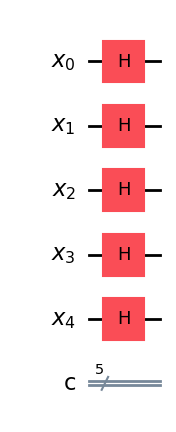

In [2]:
x = QuantumRegister(5, "x")
c = ClassicalRegister(5, "c")

qc = QuantumCircuit(x, c)
qc.h(x)
qc.draw("mpl")


# Oracle pour une équation quadratique

Dans cette partie, nous allons construire un **oracle quantique** qui marque les états $|x⟩$ satisfaisant l’équation suivante :

$$ 7x^2 + 11x + 5 \equiv 13 \pmod{2^n}. $$

---

## Étapes de construction

1. On encode l’entrée $x$ sur $n$ qubits.
2. On calcule **en réversible** la valeur $7x^2 + 11x + 5$ dans un registre de travail.
3. On compare le résultat à $13$ :
   - si égalité, on applique une **inversion de phase** (porte Z contrôlée).
   - sinon, rien ne se passe.
4. On efface (uncompute) le registre de travail pour revenir à l’état initial.

Ainsi, après application de l’oracle $O$, on obtient :

$$ 
O|x⟩ =
\begin{cases}
-|x⟩ & \text{si } 7x^2 + 11x + 5 \equiv 13 \pmod{2^n}, \\
\ \ |x⟩ & \text{sinon.}
\end{cases}
$$

---

## Vérification classique des solutions

Avant de lancer Grover, on peut vérifier **par calcul classique** quels $x$ satisfont l’équation pour $n=5$ (donc $x \in [0,31]$) :

$$
7x^2 + 11x + 5 \equiv 13 \pmod{32}.
$$

Quelques tests :

- Pour $x=1$ : $7\cdot 1^2 + 11\cdot 1 + 5 = 23 \not\equiv 13 \pmod{32}$.
- Pour $x=2$ : $7\cdot 4 + 22 + 5 = 55 \equiv 23 \pmod{32}$, pas solution.
- Pour $x=3$ : $7\cdot 9 + 33 + 5 = 101 \equiv 5 \pmod{32}$, pas solution.
- Pour $x=4$ : $7\cdot 16 + 44 + 5 = 161 \equiv 1 \pmod{32}$, pas solution.
- Pour $x=5$ : $7\cdot 25 + 55 + 5 = 230 \equiv 6 \pmod{32}$, pas solution.

... (on peut continuer avec un petit code Python pour scanner tous les $x$).

---

## Objectif

Une fois l’oracle construit, on utilisera l’algorithme de Grover pour amplifier uniquement les états $|x⟩$ qui sont solutions de cette équation.  
Lors de la mesure, les solutions devraient apparaître avec une probabilité proche de $1$.


In [2]:

import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import Diagonal
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

# --- Oracle diagonal
def oracle_diagonal_quadratic(n=5):
    N = 2**n
    diag = []
    for x in range(N):
        val = (7*x*x + 11*x + 5) % (2**n)
        diag.append(-1 if val == 13 else 1)
    xreg = QuantumRegister(n, "x")
    qc = QuantumCircuit(xreg, name="O_diag")
    qc.append(Diagonal(diag), xreg[:])   # reste un QuantumCircuit
    return qc

# --- Diffuseur
def diffuser(n):
    x = QuantumRegister(n, 'x')
    qc = QuantumCircuit(x, name="D")
    qc.h(x); qc.x(x)
    qc.h(x[-1])
    qc.mcx(list(x[:-1]), x[-1])
    qc.h(x[-1])
    qc.x(x); qc.h(x)
    return qc

# --- Algorithme de Grover
def grover_quadratic_example(n=5, iters=None):
    x = QuantumRegister(n, "x")
    c = ClassicalRegister(n, "c")
    qc = QuantumCircuit(x, c)

    qc.h(x)  # superposition uniforme

    O_circ = oracle_diagonal_quadratic(n)
    D_circ = diffuser(n)

    N = 2**n
    k = iters if iters is not None else int(np.floor(np.pi/4*np.sqrt(N)))

    for _ in range(k):
        qc.append(O_circ, x[:])   # directement append le circuit
        qc.append(D_circ, x[:])

    qc.measure(x, c)

    # décomposer pour Aer
    qc = qc.decompose(reps=5)
    return qc

# --- Simulation
backend = AerSimulator()
qc = grover_quadratic_example(n=5)
result = backend.run(qc, shots=2048).result()
counts = result.get_counts()

print("Résultats :", counts)
plot_histogram(counts)
plt.show()

/tmp/ipykernel_1151/3278438937.py:17: DeprecationWarning: The class ``qiskit.circuit.library.generalized_gates.diagonal.Diagonal`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use DiagonalGate instead.
  qc.append(Diagonal(diag), xreg[:])   # reste un QuantumCircuit


Résultats : {'11101': 37, '00101': 35, '00010': 41, '11000': 562, '11110': 26, '00100': 20, '10000': 29, '11111': 29, '11011': 28, '00011': 37, '00111': 27, '01011': 587, '01001': 28, '10001': 37, '11010': 21, '01000': 30, '01100': 32, '10010': 32, '00110': 34, '00001': 30, '11100': 27, '10101': 25, '10011': 26, '01111': 32, '01010': 30, '10110': 28, '01110': 23, '10111': 33, '10100': 35, '11001': 30, '00000': 29, '01101': 28}


/tmp/ipykernel_1151/3730619428.py:16: DeprecationWarning: The class ``qiskit.circuit.library.generalized_gates.diagonal.Diagonal`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use DiagonalGate instead.
  qc.append(Diagonal(diag), xreg[:])
/tmp/ipykernel_1151/3730619428.py:16: DeprecationWarning: The class ``qiskit.circuit.library.generalized_gates.diagonal.Diagonal`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use DiagonalGate instead.
  qc.append(Diagonal(diag), xreg[:])


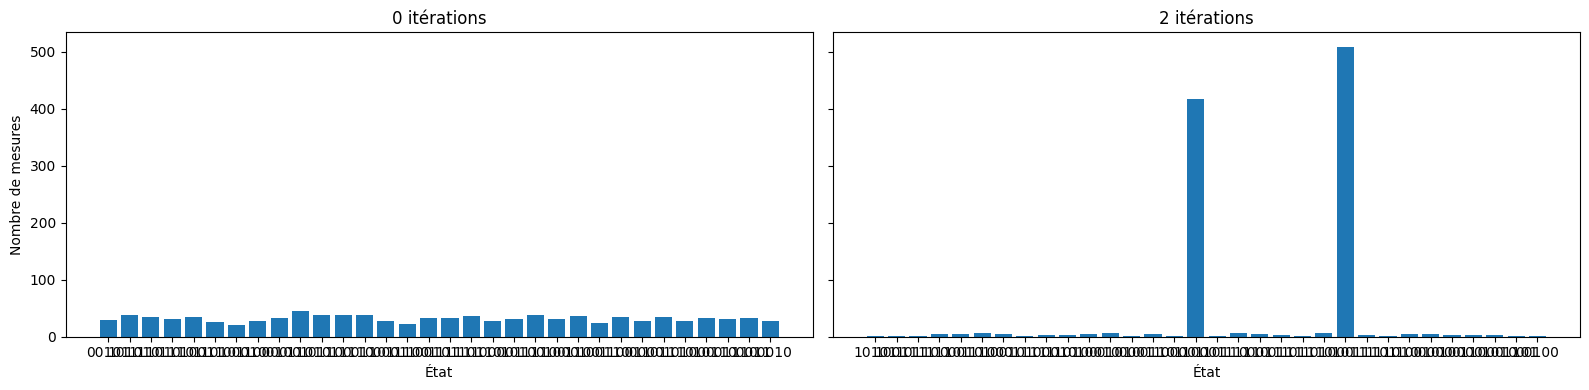

In [9]:

import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import Diagonal
from qiskit_aer import AerSimulator
import matplotlib.pyplot as plt

# --- Oracle diagonal basé sur l’équation (7x^2 + 11x + 5) % 32 == 13
def oracle_diagonal_quadratic(n=5):
    N = 2**n
    diag = []
    for x in range(N):
        val = (7*x*x + 11*x + 5) % (2**n)
        diag.append(-1 if val == 13 else 1)
    xreg = QuantumRegister(n, "x")
    qc = QuantumCircuit(xreg, name="O_diag")
    qc.append(Diagonal(diag), xreg[:])
    return qc

# --- Diffuseur
def diffuser(n):
    x = QuantumRegister(n, 'x')
    qc = QuantumCircuit(x, name="D")
    qc.h(x); qc.x(x)
    qc.h(x[-1])
    qc.mcx(list(x[:-1]), x[-1])
    qc.h(x[-1])
    qc.x(x); qc.h(x)
    return qc

# --- Construire le circuit Grover avec k itérations
def grover_quadratic_example(n=5, iters=1):
    x = QuantumRegister(n, "x")
    c = ClassicalRegister(n, "c")
    qc = QuantumCircuit(x, c)

    qc.h(x)  # superposition uniforme

    O_circ = oracle_diagonal_quadratic(n)
    D_circ = diffuser(n)

    for _ in range(iters):
        qc.append(O_circ, x[:])
        qc.append(D_circ, x[:])

    qc.measure(x, c)

    # décomposer pour compatibilité Aer
    qc = qc.decompose(reps=5)
    return qc

# --- Simulation et visualisation pour plusieurs itérations
backend = AerSimulator()
iters_list = [0,2]   # nombre d’itérations testées
counts_list = []

for k in iters_list:
    qc = grover_quadratic_example(n=5, iters=k)
    result = backend.run(qc, shots=1024).result()
    counts = result.get_counts()
    counts_list.append(counts)

# --- Visualisation
fig, axes = plt.subplots(1, len(iters_list), figsize=(16,4), sharey=True)

for idx, k in enumerate(iters_list):
    counts = counts_list[idx]
    states = list(counts.keys())
    values = list(counts.values())
    axes[idx].bar(states, values)
    axes[idx].set_title(f"{k} itérations")
    axes[idx].set_xlabel("État")
    if idx == 0:
        axes[idx].set_ylabel("Nombre de mesures")

plt.tight_layout()
plt.show()


## Vérification classique

Avant de construire l’oracle, vérifions par calcul classique quelles sont les solutions $x \in \{0,\dots,31\}$.


In [6]:
solutions = []
for x in range(32):
    if (7*x*x + 11*x + 5) % 32 == 13:
        solutions.append(x)

print("Solutions classiques :", solutions)


Solutions classiques : [11, 24]
